In [205]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df1 = pd.read_csv('code/statistics/08-04-2018.csv')
df = df1[df1['state'] == 'SUCCEEDED']
print(df.columns)

Index(['state', 'submitTime', 'startTime', 'finishTime', 'queueTime',
       'runTime', 'NumMaps', 'avgMapTime', 'avgReduceTime', 'avgShuffleTime',
       'avgMergeTime', 'NumReduce', 'HDFS_INPUT_SIZE', 'HDFS_OUTPUT_SIZE',
       'MAP_CPU_USAGE_MSEC', 'REDUCE_CPU_USAGE_MSEC', 'MAP_MEM_USAGE_B',
       'REDUCE_MEM_USAGE_B', 'HIVE_RECORDS_IN', 'HIVE_RECORDS_OUT',
       'HIVE_RECORDS_INTERMEDIATE', 'SLOTS_MILLIS_MAPS',
       'SLOTS_MILLIS_REDUCES', 'TOTAL_LAUNCHED_MAPS', 'TOTAL_LAUNCHED_REDUCES',
       'DATA_LOCAL_MAPS', 'RACK_LOCAL_MAPS', 'MILLIS_MAPS', 'MILLIS_REDUCES',
       'VCORES_MILLIS_MAPS', 'VCORES_MILLIS_REDUCES', 'MB_MILLIS_MAPS',
       'MB_MILLIS_REDUCES', 'PHMAP_MEM_USAGE_B', 'PHREDUCE_MEM_USAGE_B',
       'PHPHYSICAL_MEMORY_B', 'jobid', 'job.maps', 'query', 'outputdir',
       'scratchdir', 'sessionid', 'query.id', 'local.scratchdir', 'user.name',
       'job', 'n_inputs', 'inputdir', 'workflow.node', 'workflow.id',
       'workflow.dag', 'table.name'],
      dtype='obj

/home/maniaa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/maniaa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/maniaa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2018-08-04 06:59:46 	 2018-08-05 06:59:30 
 first job: 5 , last second: 86396
71.0 2.0
2602 1
Done


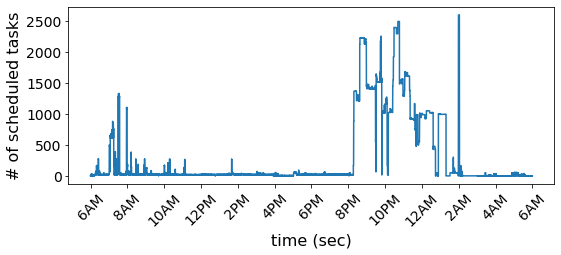

In [149]:
# compute number of active task
# compute number of running mappers 
min_ts = df['submitTime'].min()//1000
max_ts = df['submitTime'].max()//1000
df['submittimestamp'] = df['submitTime']//1000 - min_ts;
df['starttimestamp'] = df['startTime']//1000 - min_ts;
df['finishtimestamp'] = df['finishTime']//1000 - min_ts

df2 = df['finishtimestamp'] - df['starttimestamp']
print(dt.datetime.fromtimestamp(min_ts), '\t',
     dt.datetime.fromtimestamp(max_ts), '\n',
     'first job:', df['starttimestamp'].min(), ', last second:', df['finishtimestamp'].max())


# this for computing concurrent maps
df['SequentialMaps'] = ((df['runTime'] - df['avgReduceTime'])/df['avgMapTime']).apply(np.ceil)
df['ConcurrentMaps'] = df['NumMaps'] / df['SequentialMaps']
df.loc[df['ConcurrentMaps'] < 1, 'ConcurrentMaps'] = df[df['ConcurrentMaps'] < 1]['NumMaps']
df['ConcurrentMaps'] = df['ConcurrentMaps'].apply(np.ceil).astype('int64')

# this for computing concurrent tasks
df['SequentialTask'] = (df['runTime']/(df['avgMapTime'] + df['avgReduceTime'])).apply(np.ceil)
df['ConcurrentTask'] = (df['NumMaps'] + df['NumReduce']) / df['SequentialTask']
df.loc[df['ConcurrentTask'] < 1, 'ConcurrentTask'] = df[df['ConcurrentTask'] < 1]['NumMaps'] + df[df['ConcurrentTask'] < 1]['NumReduce']
df['ConcurrentTask'] = df['ConcurrentTask'].apply(np.ceil).astype('int64')


print(df['SequentialTask'].max(), df['SequentialTask'].min())
print(df['ConcurrentTask'].max(), df['ConcurrentTask'].min())

active_mappers = np.zeros((df['finishtimestamp'].max(),), dtype=int)
for index, row in df.iterrows():
    active_mappers[row['starttimestamp']:row['finishtimestamp']] += row['ConcurrentTask']
print('Done')

def format_xticks(x, pos=None):
    hour = int(x)//3600
    daytime = ''
    if 0 <= hour and hour < 6:
        daytime = 'AM'
        hour += 6;
    elif hour == 6:
        daytime = 'PM'
        hour += 6;
    elif 6 < hour and hour < 18:
        daytime = 'PM'
        hour -= 6;
    elif hour == 18:
        daytime = 'AM'
        hour -= 6;
    elif 18 < hour and hour <= 24:
        daytime = 'AM'
        hour -= 18;
    return str(hour) + daytime

fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(active_mappers)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.tick_params(labelsize=14)
plt.xlabel("time (sec)", fontsize=16)
plt.ylabel("# of scheduled tasks", fontsize=16)
plt.xticks(np.arange(0, len(active_mappers)+3600, 7200), rotation=45)
plt.subplots_adjust(left=0.21, bottom=0.15, right=0.96, top=0.97)
fig.savefig('../fig_activemappers.pdf', format='pdf', dpi=200)
fig.savefig('../fig_activemappers.png', format='png', dpi=200)
plt.show()

In [201]:
def cluster_cpuutilization(fpath):
    df1 = pd.read_csv(fpath)
    df = df1[df1['state'] == 'SUCCEEDED']
    print(df.columns)
    
    df['MapUtilization'] = (df['MILLIS_MAPS']/df['SLOTS_MILLIS_MAPS']) 
    df['ReduceUtilization'] = df['TOTAL_LAUNCHED_REDUCES']*0
    df.loc[df['TOTAL_LAUNCHED_REDUCES'] > 0, 'ReduceUtilization'] = df[df['TOTAL_LAUNCHED_REDUCES'] > 0]['MILLIS_REDUCES']/df[df['TOTAL_LAUNCHED_REDUCES'] > 0]['SLOTS_MILLIS_REDUCES']
    df['JobUtilization'] = (df['MapUtilization']*df['NumMaps'] + df['TOTAL_LAUNCHED_REDUCES']*df['ReduceUtilization'])/(df['NumMaps']+df['SLOTS_MILLIS_REDUCES'])

    print(df['JobUtilization'].max(), df['JobUtilization'].min()) 

    cusec = np.zeros((df['finishtimestamp'].max(),), dtype=float)
    for index, row in df.iterrows():
        cusec[row['starttimestamp']:row['finishtimestamp']] += (row['JobUtilization'])

    cluster_utilization = np.zeros((df['finishtimestamp'].max()//300 + 2,), dtype=float)
    maxcluster_utilization = np.zeros((df['finishtimestamp'].max()//300 + 2,), dtype=float)
    mincluster_utilization = np.zeros((df['finishtimestamp'].max()//300 + 2,), dtype=float)
    for i in range(0, df['finishtimestamp'].max(), 300):
        cluster_utilization[i//300] = np.average(cusec[i:i+300])
        maxcluster_utilization[i//300] = np.max(cusec[i:i+300])
        mincluster_utilization[i//300] = np.min(cusec[i:i+300])
    print(min(cluster_utilization), max(cluster_utilization))
    
    fig, ax = plt.subplots(figsize=(9, 3))
    #ax.scatter(x=np.arange(0, len(cluster_utilization)), y = cluster_utilization)
    ax.plot(cluster_utilization)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks2))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticks))
    ax.tick_params(labelsize=14)
    plt.xlabel("time (5 min)", fontsize=16)
    plt.ylabel("Cluster CPU utilization", fontsize=16)
    plt.xticks(np.arange(0, df['finishtimestamp'].max()//300 + 2, 24), rotation=45)
    plt.subplots_adjust(left=0.21, bottom=0.15, right=0.96, top=0.97)
    fig.savefig('../fig_activemappers.pdf', format='pdf', dpi=200)
    fig.savefig('../fig_activemappers.png', format='png', dpi=200)
    plt.show()

/home/maniaa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/maniaa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/maniaa/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

0.20000000000000004 9.716541521875879e-08
0.0 0.44201432926746576


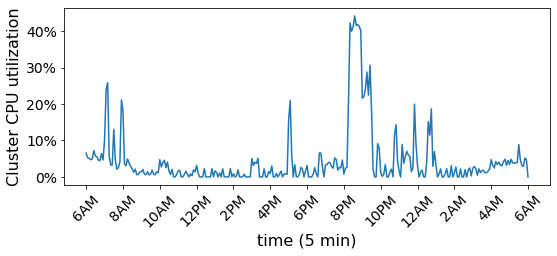

In [202]:
def format_yticks(y, pos=None):
    return str(int(float(y)*100)) + '%'

def format_xticks2(x, pos=None):
    hour = (int(x)*300)//3600
    daytime = ''
    if 0 <= hour and hour < 6:
        daytime = 'AM'
        hour += 6;
    elif hour == 6:
        daytime = 'PM'
        hour += 6;
    elif 6 < hour and hour < 18:
        daytime = 'PM'
        hour -= 6;
    elif hour == 18:
        daytime = 'AM'
        hour -= 6;
    elif 18 < hour and hour <= 24:
        daytime = 'AM'
        hour -= 18;
    return str(hour) + daytime



/home/maniaa/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


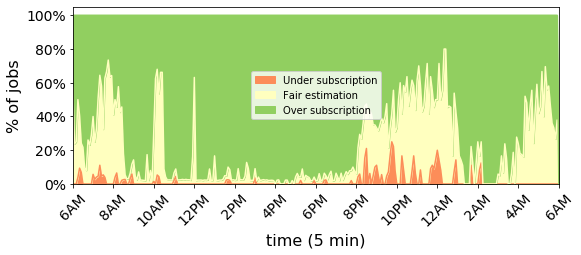

In [200]:
def cluster_oversubscription(fpath): 
    df1 = pd.read_csv(fpath)
    df = df1[df1['state'] == 'SUCCEEDED']
    print(df.columns)
    
    df.loc[:, 'CPUUtilization'] = (df.loc[:, 'MAP_CPU_USAGE_MSEC'] + df.loc[:, 'REDUCE_CPU_USAGE_MSEC'])/(df.loc[:, 'VCORES_MILLIS_MAPS'] + df.loc[:, 'VCORES_MILLIS_REDUCES'])

    dfdict = {'oversubscription' : [0]*(df['finishtimestamp'].max()//300 + 2),
           'fair_estimation' : [0]*(df['finishtimestamp'].max()//300 + 2),
           'undersubscription' : [0]*(df['finishtimestamp'].max()//300 + 2),
            'n_jobs' : [0]*(df['finishtimestamp'].max()//300 + 2)}

    for index, row in df.iterrows():
        for i in range(row['starttimestamp']//300, row['finishtimestamp']//300 + 1):
            dfdict['n_jobs'][i] += 1
            if row['CPUUtilization'] > 1.2:
                dfdict['undersubscription'][i] += 1
            elif row['CPUUtilization'] >= 0.8 and row['CPUUtilization'] <= 1.2:
                dfdict['fair_estimation'][i] += 1
            else:
                dfdict['oversubscription'][i] += 1


    df2 = pd.DataFrame(data=dfdict)
    df2.loc[:, 'Over subscription'] = 0
    df2.loc[df2['n_jobs'] > 0, 'Over subscription'] = df2.loc[df2['n_jobs'] > 0, 'oversubscription']/df2.loc[df2['n_jobs'] > 0, 'n_jobs']

    df2.loc[:, 'Under subscription'] = 0
    df2.loc[df2['n_jobs'] > 0, 'Under subscription'] = df2.loc[df2['n_jobs'] > 0, 'undersubscription']/df2.loc[df2['n_jobs'] > 0, 'n_jobs']

    df2.loc[:, 'Fair estimation'] = 0
    df2.loc[df2['n_jobs'] > 0, 'Fair estimation'] = df2.loc[df2['n_jobs'] > 0, 'fair_estimation']/df2.loc[df2['n_jobs'] > 0, 'n_jobs']


    colors = ['#fc8d59', '#ffffbf', '#91cf60']
    fig, ax = plt.subplots(figsize=(9, 3))
    df2[['Under subscription', 'Fair estimation', 'Over subscription']].plot.area(ax=ax, color=colors)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks2))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticks))
    ax.tick_params(labelsize=14)
    plt.xlabel("time (5 min)", fontsize=16)
    plt.ylabel("% of jobs", fontsize=16)
    plt.xticks(np.arange(0, df['finishtimestamp'].max()//300 + 2, 24), rotation=45)
    plt.subplots_adjust(left=0.21, bottom=0.15, right=0.96, top=0.97)
    fig.savefig('../fig_cpuoversubscription.pdf', format='pdf', dpi=200)
    fig.savefig('../fig_cpuoversubscription.png', format='png', dpi=200)
    plt.show()

In [ ]:
# compute number of active task
# compute number of running mappers 
min_ts = df['submitTime'].min()//1000
max_ts = df['submitTime'].max()//1000
df['submittimestamp'] = df['submitTime']//1000 - min_ts;
df['starttimestamp'] = df['startTime']//1000 - min_ts;
df['finishtimestamp'] = df['finishTime']//1000 - min_ts

print(dt.datetime.fromtimestamp(min_ts), '\t',
     dt.datetime.fromtimestamp(max_ts), '\n',
     'first job:', df['starttimestamp'].min(), ', last second:', df['finishtimestamp'].max())


# this for computing concurrent maps
df['SequentialMaps'] = ((df['runTime'] - df['avgReduceTime'])/df['avgMapTime']).apply(np.ceil)
df['ConcurrentMaps'] = df['NumMaps'] / df['SequentialMaps']
df.loc[df['ConcurrentMaps'] < 1, 'ConcurrentMaps'] = df[df['ConcurrentMaps'] < 1]['NumMaps']
df['ConcurrentMaps'] = df['ConcurrentMaps'].apply(np.ceil).astype('int64')

# this for computing concurrent tasks
df['SequentialTask'] = (df['runTime']/(df['avgMapTime'] + df['avgReduceTime'])).apply(np.ceil)
df['ConcurrentTask'] = (df['NumMaps'] + df['NumReduce']) / df['SequentialTask']
df.loc[df['ConcurrentTask'] < 1, 'ConcurrentTask'] = df[df['ConcurrentTask'] < 1]['NumMaps'] + df[df['ConcurrentTask'] < 1]['NumReduce']
df['ConcurrentTask'] = df['ConcurrentTask'].apply(np.ceil).astype('int64')


print(df['SequentialTask'].max(), df['SequentialTask'].min())
print(df['ConcurrentTask'].max(), df['ConcurrentTask'].min())



access_time = np.zeros((df['finishtimestamp'].max(),), dtype=int)
for index, row in df.iterrows():
    active_mappers[row['starttimestamp']:row['finishtimestamp']] += row['HDFS_INPUT_SIZE']/(row['finishtimestamp'] - row['starttimestamp'])
print('Done')
